## **I. Google Colab Initializtion (Only on Colab)**

In [95]:
# from google.colab import drive
# drive.mount('/content/drive')
# cur_dir = "/content/drive/Othercomputers/My laptop/POLIMI/AN2DL/AN2DL_CH_2/Notebooks"
# %cd $cur_dir


In [96]:
#%pip install torchview

## **1. Import Libraries**

In [97]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path
import shutil

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'pkill' is not recognized as an internal or external command,
operable program or batch file.


PyTorch version: 2.5.1
Device: cuda


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file models already exists.
Error occurred while processing: models.


## **2. Preprocessing**

- Preprocessing pipeline : 
    - Get Loaded Images
    - Create Goo Masks
    - Apply Goo Removal + Resizing
    - Discard Shrek Images
    - Apply the external Masks (optional)
    

In [98]:
def _get_smart_goo_mask(img_bgr):
    """
    Internal helper to detect goo using Core & Shell logic + 1px Nudge.
    Returns a binary mask (White = Goo, Black = Safe).
    """
    # 1. Convert to HSV
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # 2. Define Ranges
    # CORE: Solid Green (Strict)
    core_lower = np.array([35, 100, 50])
    core_upper = np.array([85, 255, 255])
    
    # SHELL: Faint Halo (Loose/Transparent)
    shell_lower = np.array([30, 30, 30])
    shell_upper = np.array([95, 255, 255])

    # 3. Create initial masks
    mask_core = cv2.inRange(hsv, core_lower, core_upper)
    mask_shell = cv2.inRange(hsv, shell_lower, shell_upper)

    # 4. Smart Combine (Connected Components)
    # Keep 'Shell' blobs ONLY if they touch 'Core' blobs
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_shell, connectivity=8)
    smart_mask = np.zeros_like(mask_core)

    for label_id in range(1, num_labels): # Skip background (0)
        blob_mask = (labels == label_id).astype(np.uint8) * 255
        
        # Check overlap with Core
        overlap = cv2.bitwise_and(blob_mask, mask_core)
        
        # If there is ANY overlap, keep the blob
        if cv2.countNonZero(overlap) > 0:
            smart_mask = cv2.bitwise_or(smart_mask, blob_mask)

    # 5. Fill Holes (in case the goo has shiny reflections)
    contours, _ = cv2.findContours(smart_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_filled_mask = np.zeros_like(smart_mask)
    for contour in contours:
        # Minimum area filter (200px) to remove tiny stray noise
        if cv2.contourArea(contour) > 200:
            cv2.drawContours(final_filled_mask, [contour], -1, (255), thickness=cv2.FILLED)

    # 6. The "1-Pixel Nudge"
    # Safely expand by 1 pixel to cover the final anti-aliased fringe
    kernel = np.ones((3, 3), np.uint8)
    final_expanded_mask = cv2.dilate(final_filled_mask, kernel, iterations=1)

    return final_expanded_mask



In [99]:
def resize_batch(input_dir, output_dir, target_size=(300, 300), remove_goo=True):
    """
    Iterates through input_dir, finds 'img_xxxx', resizes them to target_size, 
    and saves the result to output_dir.
    If remove_goo is True, it subtracts green pixels (using Smart Core/Shell logic).
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Extensions to look for
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    
    # 1. Gather all valid image files first
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir() 
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]
    
    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    # 2. Iterate with tqdm
    count = 0
    
    for file_path in tqdm(image_files, desc="Resizing Images", unit="img"):
        output_path = output_dir / file_path.name
        
        if output_path.exists():
            # Skip silently
            continue

        img = cv2.imread(str(file_path))
        if img is None:
            continue
            
        if target_size is not None:
            img = cv2.resize(img, target_size)
            
        if remove_goo:
            # --- NEW SMART GOO LOGIC ---
            # Get the smart mask (White = Goo)
            goo_mask = _get_smart_goo_mask(img)
            
            # Invert Goo Mask (White = Safe)
            not_goo_mask = cv2.bitwise_not(goo_mask)
            
            # Apply Mask
            img = cv2.bitwise_and(img, img, mask=not_goo_mask)
            
        cv2.imwrite(str(output_path), img)
        count += 1

    print(f"Resizing complete. Processed {count} new images.")

In [100]:
def apply_mask(image_path, mask_path, output_path, target_size=(300, 300), remove_goo=True):
    """
    Loads an image and a mask. 
    If remove_goo is True, it subtracts green pixels (using Smart Core/Shell logic) 
    from the valid mask area. Resizes and saves the result.
    """
    # 1. Load Image
    img = cv2.imread(str(image_path))
    if img is None:
        tqdm.write(f"Error: Could not load image at {image_path}")
        return

    # 2. Load External Mask (Read as grayscale)
    mask = cv2.imread(str(mask_path), 0)
    if mask is None:
        tqdm.write(f"Error: Could not load mask at {mask_path}")
        return

    # 3. Resize both to target size
    if target_size is not None:
        img = cv2.resize(img, target_size)
        mask = cv2.resize(mask, target_size)

    # 4. Standardize External Mask (Binary 0 or 255)
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # 5. Determine Final Mask
    if remove_goo:
        # --- NEW SMART GOO LOGIC ---
        # Get the smart mask (White = Goo)
        goo_mask = _get_smart_goo_mask(img)
        
        # Invert Goo Mask (White = Safe)
        not_goo_mask = cv2.bitwise_not(goo_mask)
        
        # Combine: Must be Tissue (binary_mask) AND Safe (not_goo_mask)
        final_mask = cv2.bitwise_and(binary_mask, not_goo_mask)
    else:
        # --- ORIGINAL LOGIC ---
        final_mask = binary_mask

    # 6. Apply Final Mask
    # Areas outside the final mask become Black (0)
    masked_img = cv2.bitwise_and(img, img, mask=final_mask)

    # 7. Save result
    # Ensure output directory exists
    os.makedirs(os.path.dirname(str(output_path)), exist_ok=True)
    cv2.imwrite(str(output_path), masked_img)

In [101]:
def filter_bright_green_areas(image, lg_H=20, lg_S=45, lg_V=0, ug_H=84, ug_S=255, ug_V=255, dilate_iterations=2):
    """
    Filters out bright green areas from the input image with improved residual removal.
    
    Args:
        image: Input image in RGB format (0-1 range)
        lg_H, lg_S, lg_V: Lower bounds for HSV green detection
        ug_H, ug_S, ug_V: Upper bounds for HSV green detection
        dilate_iterations: Number of dilation iterations to expand mask (removes edge artifacts)
    """

    # Convert from RGB (0-1) to BGR (0-255) for OpenCV
    original_bgr = (image * 255).astype(np.uint8)[..., ::-1]

    # 1. Convert to HSV (Hue, Saturation, Value)
    hsv = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2HSV)

    # 2. Define the "Bright Green" Range
    lower_green = (lg_H, lg_S, lg_V)
    upper_green = (ug_H, ug_S, ug_V)

    # Create the initial mask
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # 3. Morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # OPEN: Remove small noise
    clean_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # DILATE: Expand the mask to catch edge artifacts and residuals
    # This ensures we remove green pixels at the boundaries
    if dilate_iterations > 0:
        clean_mask = cv2.dilate(clean_mask, kernel, iterations=dilate_iterations)

    # 4. Additional step: Detect any remaining green-ish pixels
    # Create a more aggressive mask for subtle green tones
    lower_green_subtle = (max(0, lg_H - 10), max(0, lg_S - 10), 0)
    upper_green_subtle = (min(180, ug_H + 10), 255, 255)
    subtle_mask = cv2.inRange(hsv, lower_green_subtle, upper_green_subtle)
    
    # Only keep subtle green pixels that are near the main green area
    subtle_mask = cv2.morphologyEx(subtle_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Combine masks
    combined_mask = cv2.bitwise_or(clean_mask, subtle_mask)

    # 5. Invert mask to keep the useful parts
    mask_inv = cv2.bitwise_not(combined_mask)

    # 6. Apply the mask
    result_bgr = cv2.bitwise_and(original_bgr, original_bgr, mask=mask_inv)

    return result_bgr, combined_mask

In [102]:
def analyze_dataset_for_shreks(directory, ratio_threshold=0.0125):
    shrek_images = []
    tissue_images = []
    
    image_files = glob.glob(os.path.join(directory, 'img_*.png'))
    print(f"Found {len(image_files)} images in {directory}")

    for f in image_files:
        try:
            # Load image (BGR)
            img = cv2.imread(f)
            if img is None: continue
            
            # Prepare image for the new filter: Convert BGR to RGB (0-1 float)
            img_rgb_norm = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            
            # Apply Filter
            result_bgr, mask = filter_bright_green_areas(img_rgb_norm)
            
            # Calculate Ratio of Green Pixels from the combined mask
            total_pixels = img.shape[0] * img.shape[1]
            green_pixels = np.count_nonzero(mask)
            ratio = green_pixels / total_pixels
            
            # Convert BGR to RGB for plotting
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            entry = {
                'name': os.path.basename(f), 
                'path': f,
                'img': img_rgb, 
                'ratio': ratio,
                'mask': mask
            }

            # === CLASSIFICATION LOGIC ===
            if ratio > ratio_threshold:
                shrek_images.append(entry)
            else:
                tissue_images.append(entry)
                
        except Exception as e:
            print(f"Skipping {f}: {e}")

    return shrek_images, tissue_images

In [103]:
def process_batch(input_dir, output_dir, target_size=(300, 300), remove_goo=True):
    """
    Iterates through input_dir, finds pairs of 'img_xxxx' and 'mask_xxxx'.
    Passes the remove_goo flag to the apply_mask function.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    
    output_dir.mkdir(parents=True, exist_ok=True)
    
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir() 
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]
    
    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    count = 0
    
    for file_path in tqdm(image_files, desc="Processing Images", unit="img"):
        # Construct mask filename
        mask_name = file_path.name.replace('img_', 'mask_', 1)
        mask_path = input_dir / mask_name
        
        if not mask_path.exists():
            mask_stem = file_path.stem.replace('img_', 'mask_', 1)
            mask_path = input_dir / (mask_stem + ".png")
        
        if mask_path.exists():
            output_path = output_dir / file_path.name
            
            if output_path.exists():
                continue

            # Pass the remove_goo flag here
            apply_mask(file_path, mask_path, output_path, target_size=target_size, remove_goo=remove_goo)
            count += 1
        else:
            tqdm.write(f"Skipping {file_path.name}: No matching mask found.")

    print(f"Batch processing complete. Processed {count} new images.")



In [104]:
def process_classification_results(shrek_list, tissue_list, shrek_dir, tissue_dir, threshold):
    """
    Saves classified images to respective directories and visualizes the results.
    
    Args:
        shrek_list (list): List of dicts containing Shrek image data.
        tissue_list (list): List of dicts containing Tissue image data.
        shrek_dir (str): Path to save Shrek images.
        tissue_dir (str): Path to save Tissue images.
        threshold (float): The green ratio threshold used for classification.
    """
    
    # 1. Print Summary
    print(f"Classified {len(shrek_list)} as Shrek")
    print(f"Classified {len(tissue_list)} as Tissue")

    # Ensure directories exist
    os.makedirs(shrek_dir, exist_ok=True)
    os.makedirs(tissue_dir, exist_ok=True)

    # 2. Save Shrek images
    print(f"Saving {len(shrek_list)} Shrek images to {shrek_dir}...")
    for item in shrek_list:
        dest_path = os.path.join(shrek_dir, item['name'])
        
        # Check if file exists to prevent overwriting
        if os.path.exists(dest_path):
            continue

        try:
            shutil.copy2(item['path'], dest_path)
        except Exception as e:
            print(f"Error copying {item['name']} to shrek folder: {e}")

    # 3. Save Tissue images
    print(f"Saving {len(tissue_list)} Tissue images to {tissue_dir}...")
    for item in tissue_list:
        dest_path = os.path.join(tissue_dir, item['name'])
        
        # Check if file exists to prevent overwriting
        if os.path.exists(dest_path):
            continue

        try:
            shutil.copy2(item['path'], dest_path)
        except Exception as e:
            print(f"Error copying {item['name']} to tissue folder: {e}")

    # 4. Visualize Examples (2x2 Grid)
    if len(shrek_list) >= 2 and len(tissue_list) >= 2:
        fig_ex, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig_ex.suptitle(f"Classification Results (Threshold: {threshold:.1%})", fontsize=16)

        def show_img(ax, item, label):
            ax.imshow(item['img'])
            # Show the Green Ratio in the title so you can see WHY it was classified
            ax.set_title(f"{label}\n{item['name']}\nGreen Pixels: {item['ratio']:.2%}")
            ax.axis('off')

        # Row 1: Detected Shrek
        show_img(axes[0, 0], shrek_list[0], "Detected Shrek")
        show_img(axes[0, 1], shrek_list[1], "Detected Shrek")
        
        # Row 2: Detected Tissue
        show_img(axes[1, 0], tissue_list[0], "Detected Tissue")
        show_img(axes[1, 1], tissue_list[1], "Detected Tissue")

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough images in one or both classes to generate 2x2 sample grid.")

    # 5. Plot Scatter Distribution for Tuning
    shrek_ratios = [x['ratio'] for x in shrek_list]
    tissue_ratios = [x['ratio'] for x in tissue_list]

    plt.figure(figsize=(12, 6))

    # Plot Tissue points (Blue)
    plt.scatter(range(len(tissue_ratios)), tissue_ratios, color='blue', alpha=0.6, label='Classified as Tissue')

    # Plot Shrek points (Green) - Shifted on x-axis to be distinct
    # We shift the x-axis index for Shrek so they appear after the tissue points
    plt.scatter(range(len(tissue_ratios), len(tissue_ratios) + len(shrek_ratios)), shrek_ratios, color='green', alpha=0.6, label='Classified as Shrek')

    # Draw the Threshold Line
    plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.1%})')

    plt.title('Green Pixel Ratio per Image', fontsize=14)
    plt.ylabel('Ratio of Green Pixels (0.0 - 1.0)')
    plt.xlabel('Image Index')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- Example Usage ---
# shrek_list, tissue_list = analyze_dataset(DATASET_PATH) # Assuming this runs before
# process_classification_results(shrek_list, tissue_list, SHREK_DIR, TISSUE_DIR, RATIO_THRESHOLD)

In [105]:
def copy_masks(image_list, masks_dir, output_dir):
    image_names = [item['name'] for item in image_list]
    mask_names = [name.replace('img_', 'mask_', 1) for name in image_names]

    for mask_name in mask_names:
        src_path = os.path.join(masks_dir, mask_name)
        dst_path = os.path.join(output_dir, mask_name)
        shutil.copy(src_path, dst_path)
    
    return 



In [106]:
datasets_path = os.path.join(os.path.pardir, "an2dl2526c2")

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")
test_data_path = os.path.join(datasets_path, "test_data")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = train_data_path

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
# preprocessing output paths
#preprocessing step 1 output path
GOO_REMOVAL_OUT = os.path.join(datasets_path, "train_nogoo")

#preprocessing step 2 output path
SHREK_REMOVAL_OUT = os.path.join(datasets_path, "train_noshreks")
SHREKS_OUT = os.path.join(SHREK_REMOVAL_OUT, "train_shreks")
TISSUE_OUT = os.path.join(SHREK_REMOVAL_OUT, "train_tissue")

#preprocessing step 3 output path
FINAL_TRAIN_OUT = os.path.join(datasets_path, "train_masked_noshreks")
  # Where the resized unmasked images will be saved

TARGET_SIZE = (300, 300)                    # Target size for the resized images and masks

Dataset path: ..\an2dl2526c2
Train data path: ..\an2dl2526c2\train_data
Train labels path: ..\an2dl2526c2\train_labels.csv
Test data path: ..\an2dl2526c2\test_data


Scanning for images in: ..\an2dl2526c2\train_data...


Resizing Images: 100%|██████████| 1412/1412 [00:51<00:00, 27.16img/s]


Resizing complete. Processed 1412 new images.
Found 1412 images in ..\an2dl2526c2\train_nogoo
Classified 150 as Shrek
Classified 1262 as Tissue
Saving 150 Shrek images to ..\an2dl2526c2\train_noshreks\train_shreks...
Saving 1262 Tissue images to ..\an2dl2526c2\train_noshreks\train_tissue...


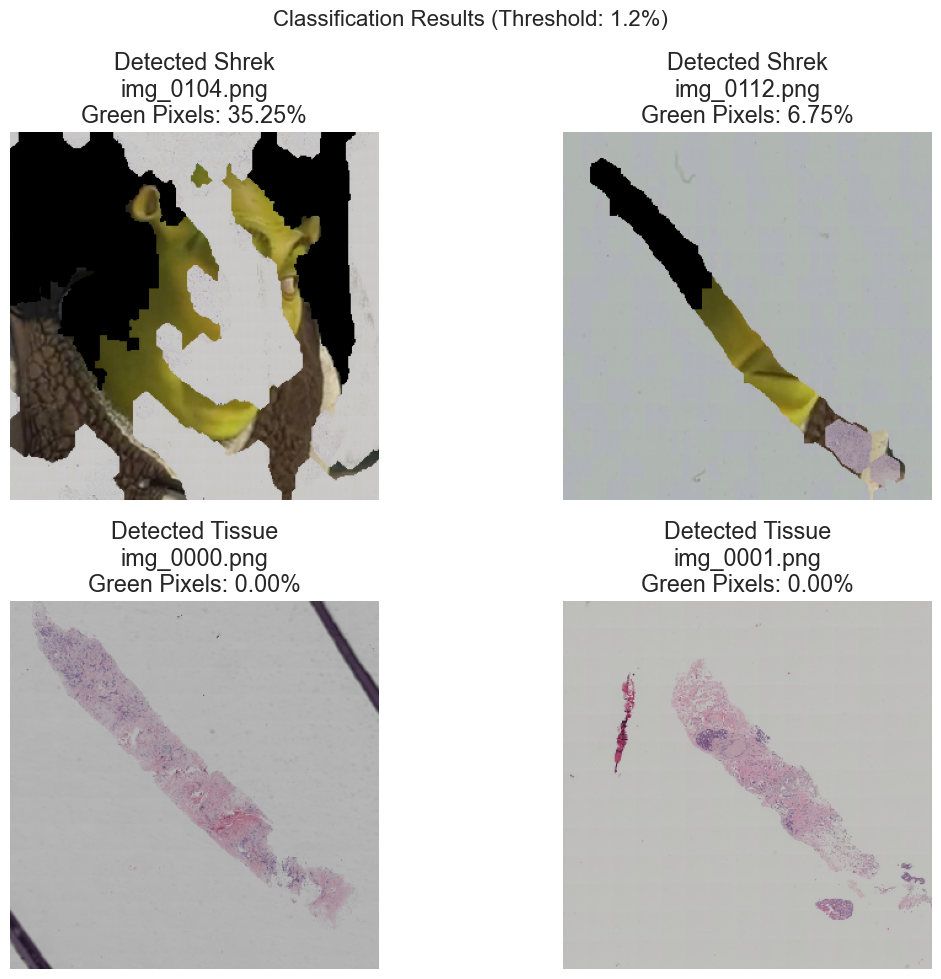

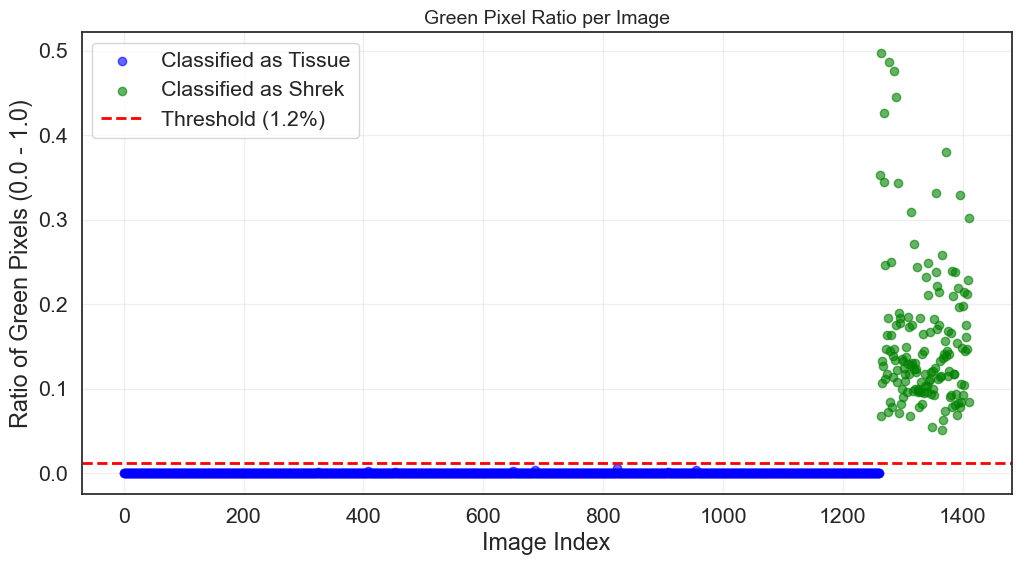

Scanning for images in: ..\an2dl2526c2\train_noshreks\train_tissue...


Processing Images: 100%|██████████| 1262/1262 [00:28<00:00, 44.04img/s]

Batch processing complete. Processed 1262 new images.


In [107]:
# Step 1: Remove goo and resize images
resize_batch(SOURCE_FOLDER,GOO_REMOVAL_OUT, target_size=TARGET_SIZE, remove_goo=True)

#Step 2: Discard Shrek Images
shreks_list, tissue_list = analyze_dataset_for_shreks(GOO_REMOVAL_OUT, ratio_threshold=0.0125)
process_classification_results(shreks_list, tissue_list, SHREKS_OUT, TISSUE_OUT, 0.0125)

#Step 3 : Apply the external masks
copy_masks(tissue_list, SOURCE_FOLDER, TISSUE_OUT)
copy_masks(shreks_list, SOURCE_FOLDER, SHREKS_OUT)
process_batch(TISSUE_OUT, FINAL_TRAIN_OUT, target_size=TARGET_SIZE, remove_goo=False)



## **3. Load Images From Folder**

In [108]:
def load_images_from_folder(folder, resize=None, filter_prefix=None):
    """
    Load and preprocess images from a specified folder with a progress bar.

    Args:
        folder (str): Path to the folder containing images
        resize (tuple): Target size (width, height) or None
        filter_prefix (str): Prefix to filter filenames (e.g. 'img_')

    Returns:
        tuple: (np.ndarray of images, list of filenames)
    """
    images = []
    loaded_filenames = []
    
    # Get the list of files to iterate over
    file_list = sorted(os.listdir(folder))
    
    # Filter files before iterating to show correct progress
    if filter_prefix:
        file_list = [f for f in file_list if f.startswith(filter_prefix)]

    # Iterate through files with a tqdm progress bar
    for filename in tqdm(file_list, desc=f"Loading images from {os.path.basename(folder)}"):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        # Check if image was loaded successfully right away
        if img is None:
            # print(f"Warning: Failed to load image at {img_path}. Skipping.")
            continue

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255.0).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[..., ::-1]

        if resize:
            img = cv2.resize(img, resize)

        images.append(img)
        loaded_filenames.append(filename)

    return np.array(images), loaded_filenames

In [109]:
# Load masked images (already resized in process_batch)
# We add filter_prefix='img_' to ensure we don't load any mask files that might be in the folder
masked_images, masked_filenames = load_images_from_folder(FINAL_TRAIN_OUT, filter_prefix='img_')

train_images = masked_images

filenames = masked_filenames


print(f"Loaded {len(masked_images)} masked images.")
print(f"Total images: {len(train_images)}")

Loading images from train_masked_noshreks: 100%|██████████| 1262/1262 [00:13<00:00, 94.13it/s] 


Loaded 1262 masked images.
Total images: 1262


## **4. Exploration and Data Analysis**

## 4.1 Check Applied Masks

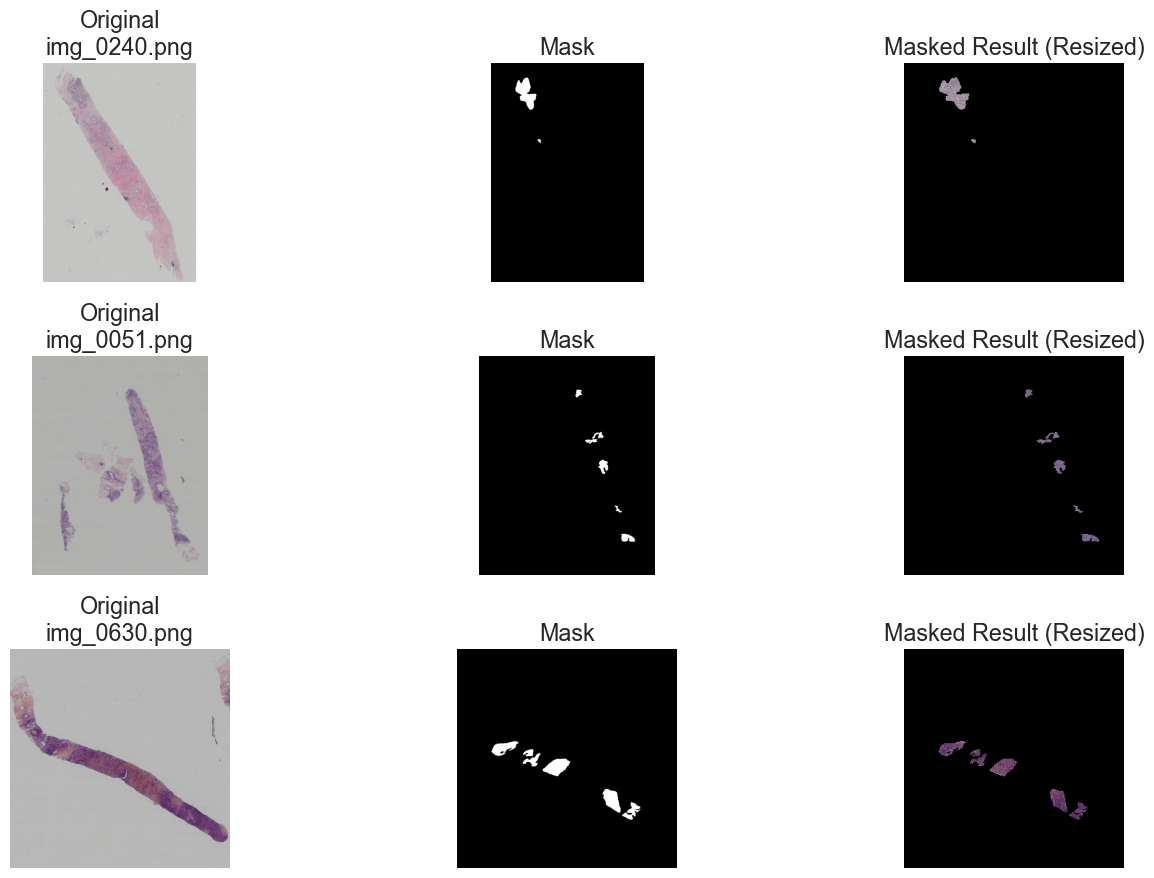

In [110]:
#@ title Mask Verification
# Select a few random images from the output folder to verify the process
masked_files = os.listdir(FINAL_TRAIN_OUT)
num_samples = 3
selected_files = random.sample(masked_files, num_samples)

fig, axes = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

for i, filename in enumerate(selected_files):
    # 1. Define paths
    masked_image_path = os.path.join(FINAL_TRAIN_OUT, filename)
    original_image_path = os.path.join(SOURCE_FOLDER, filename)
    
    # Logic to find the mask path (replicating logic from Cell 5)
    mask_name = filename.replace('img_', 'mask_', 1)
    mask_path = os.path.join(SOURCE_FOLDER, mask_name)
    
    # Check if mask exists, if not try .png fallback as per Cell 5 logic
    if not os.path.exists(mask_path):
        mask_stem = os.path.splitext(filename)[0].replace('img_', 'mask_', 1)
        mask_path = os.path.join(SOURCE_FOLDER, mask_stem + ".png")

    # 2. Load images
    # Original
    orig_img = cv2.imread(original_image_path)
    if orig_img is not None:
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    # Mask
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Masked (Result)
    masked_img = cv2.imread(masked_image_path)
    if masked_img is not None:
        masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)

    # 3. Plot
    # Original
    if orig_img is not None:
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f"Original\n{filename}")
    else:
        axes[i, 0].text(0.5, 0.5, "Original Not Found", ha='center')
    axes[i, 0].axis('off')

    # Mask
    if mask_img is not None:
        axes[i, 1].imshow(mask_img, cmap='gray')
        axes[i, 1].set_title(f"Mask")
    else:
        axes[i, 1].text(0.5, 0.5, "Mask Not Found", ha='center')
    axes[i, 1].axis('off')

    # Masked
    if masked_img is not None:
        axes[i, 2].imshow(masked_img)
        axes[i, 2].set_title(f"Masked Result (Resized)")
    else:
        axes[i, 2].text(0.5, 0.5, "Result Not Found", ha='center')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

### 3.1 Show Some Random Images

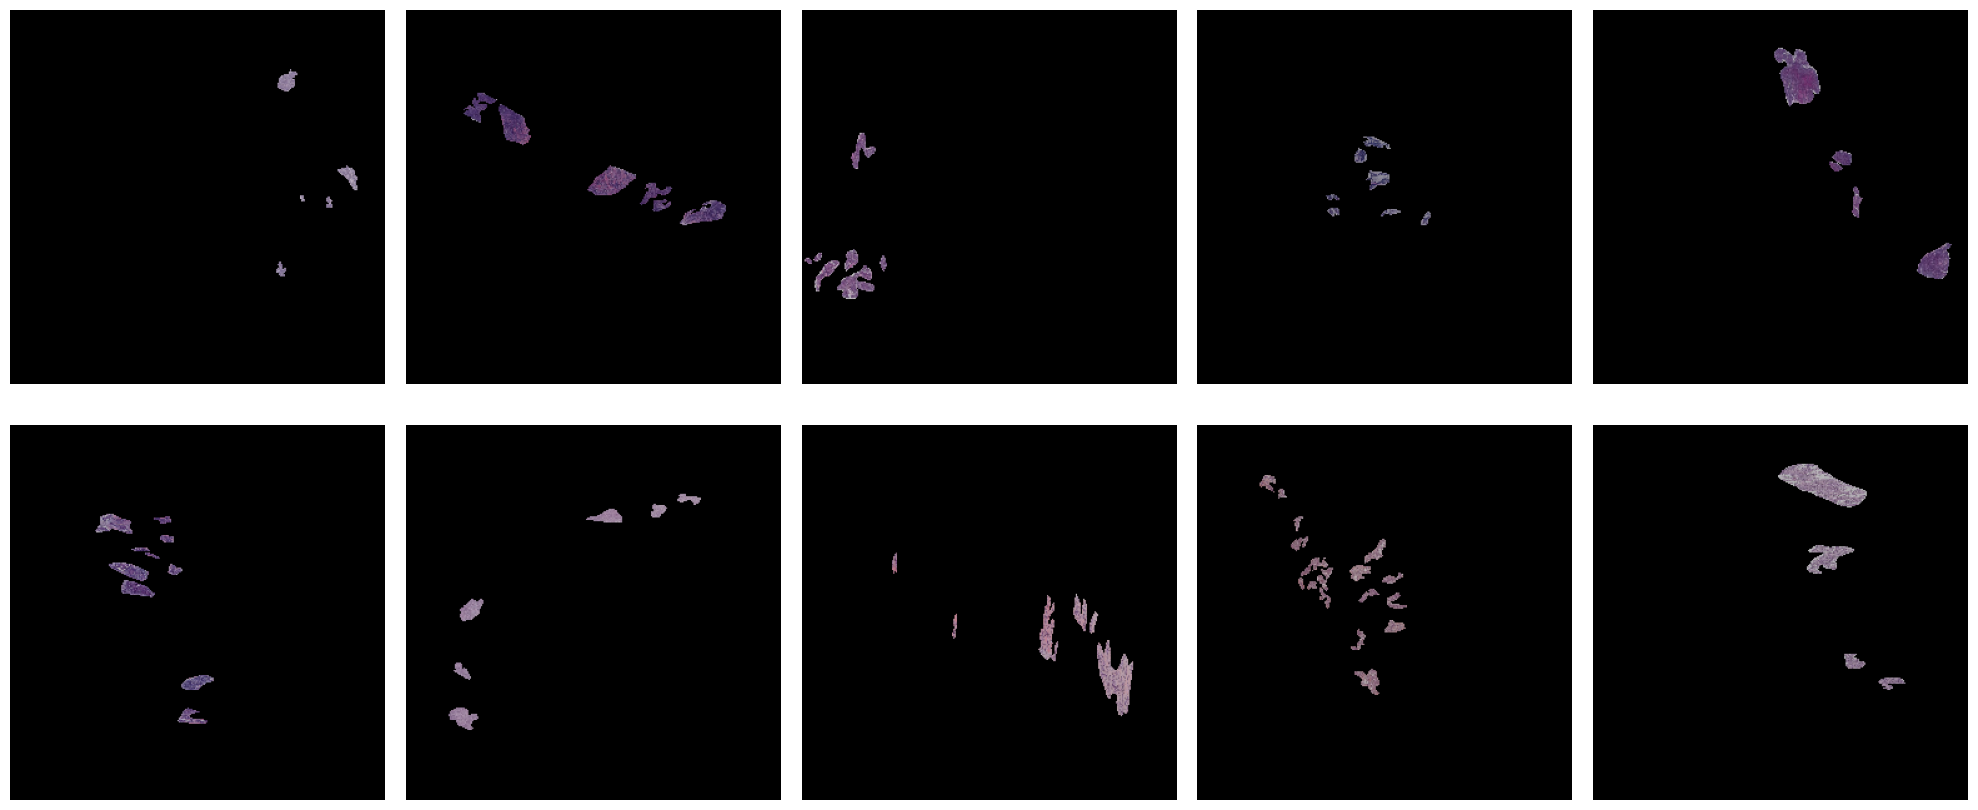

In [111]:
# Number of images to display
num_img = 10
# Starting index
start_img= random.randint(0, len(train_images) - num_img)
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(start_img, start_img+num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(train_images[i], 0, 1))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()

